In [27]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import random_split
from dataset_utils import create_dataset

def visualize_random_sample(dataset, save_path=None):
    num_samples = len(dataset)

    # Choose a random index
    rand_idx = torch.randint(0, num_samples, (1,)).item()

    # Retrieve the image and targets using the random index
    img, label = dataset[rand_idx]
    img_pil = to_pil_image(img)
    
    _, ax = plt.subplots(1)
    # # Visualize the image and its bounding boxes
    ax.imshow(img_pil, cmap="gray")
    ax.set_title(dataset.classes[label])

    if save_path:
        # Save the image to the specified path
        plt.savefig(save_path)
    else:
        # Display the image if no save_path is provided
        plt.show()


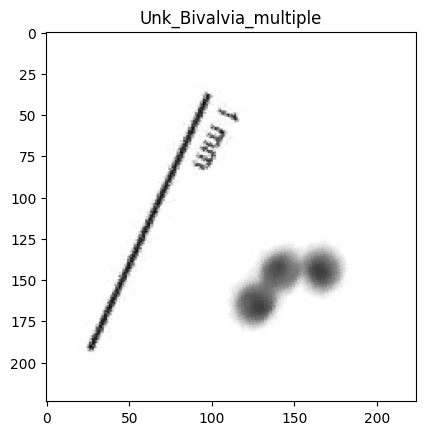

9600
2400
7500


In [36]:
from torch.utils.data import random_split

# Define transformations
transform = v2.Compose(
    [
        v2.Grayscale(num_output_channels=1),
        v2.RandomAffine(degrees=(0, 180), translate=(0, 0.1), scale=(0.95, 1.05), fill=255),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0], 
                     std=[1]),
    ]
)

# Define path
path = "./main_dataset"

# Dataset id for open-set test set
dataset_idx = 1
test_idx = [3 * (dataset_idx - 1), 3 * (dataset_idx - 1) + 1, 3 * (dataset_idx - 1) + 2]
# train_idx = list(range(3,15))

train_dataset, test_dataset = create_dataset(path, transform, test_idx=test_idx)

# Split the dataset to training and validation and further split the validation to also testing
training_set, validation_set = random_split(train_dataset, [0.8, 0.2])

visualize_random_sample(test_dataset)

batch_size = 16
trainloader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
valloader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(len(training_set))
print(len(validation_set))
print(len(test_dataset))

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

import json
import torchvision
import torchvision.transforms as tf

import argparse

import datasets.utils as dataHelper

from networks import openSetClassifier

from utils import progress_bar

import os
import numpy as np
dataset = 'PLANKTON'
trial = 0
alpha = 10
lbda = 0.1
name = "myTest"



device = 'cuda' if torch.cuda.is_available() else 'cpu'

#parameters useful when resuming and finetuning
best_acc = 0
best_cac = 10000
best_anchor = 10000
start_epoch = 0

num_classes = 15
num_known_classes = 12
im_channels = 1
im_size = 224
dropout = 0.2


#Create dataloaders for training
print('==> Preparing data..')
with open('datasets/config.json') as config_file:
	cfg = json.load(config_file)[dataset]

print('==> Building network..')
net = openSetClassifier.openSetClassifier(num_known_classes, im_channels, im_size, dropout = dropout)

# initialising with anchors
anchors = torch.diag(torch.Tensor([alpha for i in range(cfg['num_known_classes'])]))	
net.set_anchors(anchors)

net = net.to(device)

==> Preparing data..
==> Building network..


In [23]:

net.train()
optimizer = optim.SGD(net.parameters(), lr = cfg['openset_training']['learning_rate'][0], 
							momentum = 0.9, weight_decay = cfg['openset_training']['weight_decay'])

def CACLoss(distances, gt):
	'''Returns CAC loss, as well as the Anchor and Tuplet loss components separately for visualisation.'''
	true = torch.gather(distances, 1, gt.view(-1, 1)).view(-1)
	non_gt = torch.Tensor([[i for i in range(cfg['num_known_classes']) if gt[x] != i] for x in range(len(distances))]).long().cuda()
	others = torch.gather(distances, 1, non_gt)
	
	anchor = torch.mean(true)

	tuplet = torch.exp(-others+true.unsqueeze(1))
	tuplet = torch.mean(torch.log(1+torch.sum(tuplet, dim = 1)))

	total = lbda*anchor + tuplet

	return total, anchor, tuplet


# Training
def train(epoch):
	print('\nEpoch: %d' % epoch)
	net.train()
	train_loss = 0
	correctDist = 0
	total = 0

	for batch_idx, (inputs, targets) in enumerate(trainloader):
		inputs, targets = inputs.to(device), targets.to(device)
		#convert from original dataset label to known class label
		targets = torch.Tensor(targets).long().to(device)

		optimizer.zero_grad()

		outputs = net(inputs)
		cacLoss, anchorLoss, tupletLoss = CACLoss(outputs[1], targets)


		cacLoss.backward()

		optimizer.step()

		train_loss += cacLoss.item()

		_, predicted = outputs[1].min(1)

		total += targets.size(0)
		correctDist += predicted.eq(targets).sum().item()

		progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
			% (train_loss/(batch_idx+1), 100.*correctDist/total, correctDist, total))

def val(epoch):
	global best_acc
	global best_anchor
	global best_cac
	net.eval()
	anchor_loss = 0
	cac_loss = 0
	correct = 0
	total = 0
	with torch.no_grad():
		for batch_idx, (inputs, targets) in enumerate(valloader):
			inputs = inputs.to(device)
			targets = torch.Tensor(targets).long().to(device)

			outputs = net(inputs)

			cacLoss, anchorLoss, tupletLoss = CACLoss(outputs[1], targets)

			anchor_loss += anchorLoss
			cac_loss += cacLoss

			_, predicted = outputs[1].min(1)
			
			total += targets.size(0)

			correct += predicted.eq(targets).sum().item()

			progress_bar(batch_idx, len(valloader), 'Acc: %.3f%% (%d/%d)'
				% (100.*correct/total, correct, total))
   
	anchor_loss /= len(valloader)
	cac_loss /= len(valloader)
	acc = 100.*correct/total

	# Save checkpoint.
	state = {
		'net': net.state_dict(),
		'acc': acc,
		'epoch': epoch,
	}
	if not os.path.isdir('networks/weights/{}'.format(dataset)):
		os.mkdir('networks/weights/{}'.format(dataset))
  
	save_name = '{}_{}_{}CACclassifier'.format(dataset, trial, name)
	if anchor_loss <= best_anchor:
		print('Saving..')
		torch.save(state, 'networks/weights/{}/'.format(dataset)+save_name+'AnchorLoss.pth')
		best_anchor = anchor_loss


	if cac_loss <= best_cac:
		print('Saving..')
		torch.save(state, 'networks/weights/{}/'.format(dataset)+save_name+'CACLoss.pth')
		best_cac = cac_loss

	if acc >= best_acc:
		print('Saving..')
		torch.save(state, 'networks/weights/{}/'.format(dataset)+save_name+'Accuracy.pth')
		best_acc = acc


In [24]:
for epoch in range(0, 35):
	train(epoch)
	val(epoch)


Epoch: 0
 [================================================================>]  Step: 231ms | Tot: 2m20s | Loss: 4.374 | Acc: 20.729% (1990/960 600/600 0 
 [================================================================>]  Step: 82ms | Tot: 12s108ms | Acc: 30.958% (743/240 150/150 
Saving..
Saving..
Saving..

Epoch: 1
 [================================================================>]  Step: 234ms | Tot: 2m20s | Loss: 3.085 | Acc: 31.260% (3001/960 600/600 0  
 [================================================================>]  Step: 81ms | Tot: 12s100ms | Acc: 38.917% (934/240 150/150 ====>.........................................................]  Step: 89ms | Tot: 1s472ms | Acc: 42.105% (128/30 19/150 
Saving..
Saving..
Saving..

Epoch: 2
 [================================================================>]  Step: 232ms | Tot: 2m19s | Loss: 2.678 | Acc: 39.365% (3779/960 600/600 0  
 [================================================================>]  Step: 82ms | Tot: 11s983ms |

In [25]:

from utils import find_anchor_means, gather_outputs
def find_anchor_means(net, mapping, loader, only_correct = False):
    ''' Tests data and fits a multivariate gaussian to each class' logits. 
        If dataloaderFlip is not None, also test with flipped images. 
        Returns means and covariances for each class. '''
    #find gaussians for each class
    logits, labels = gather_outputs(net, mapping, loader, only_correct = only_correct)

    num_classes = num_known_classes
    means = [None for i in range(num_classes)]

    for cl in range(num_classes):
        x = logits[labels == cl]
        x = np.squeeze(x)
        means[cl] = np.mean(x, axis = 0)

    return means

In [26]:
"""
	Evaluate average performance for our proposed CAC open-set classifier on a given dataset.

	Dimity Miller, 2020
"""


import argparse
import json

import torchvision
import torchvision.transforms as tf
import torch
import torch.nn as nn

from networks import openSetClassifier
import datasets.utils as dataHelper
from utils import gather_outputs

import metrics
import scipy.stats as st
import numpy as np


dataset = 'PLANKTON'
num_trials = 1
start_trial = 0
name = 'myTest'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

all_accuracy = []
all_auroc = []

for trial_num in range(start_trial, start_trial+num_trials):
	print('==> Preparing data for trial {}..'.format(trial_num))
	with open('datasets/config.json') as config_file:
		cfg = json.load(config_file)[dataset]

	#Create dataloaders for evaluation
	train_dataset, test_dataset = create_dataset(path, transform, test_idx=test_idx)
	batch_size = 32
	knownloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
	unknownloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

	mapping = [None for i in range(num_classes)]
	
	for i in range(15):
		mapping[i] = i


	print('==> Building open set network for trial {}..'.format(trial_num))
	net = openSetClassifier.openSetClassifier(num_known_classes, im_channels, im_size, dropout = dropout)
	checkpoint = torch.load('networks/weights/{}/{}_{}_{}CACclassifierAnchorLoss.pth'.format(dataset, dataset, trial_num, name))

	net = net.to(device)
	net_dict = net.state_dict()
	pretrained_dict = {k: v for k, v in checkpoint['net'].items() if k in net_dict}
	if 'anchors' not in pretrained_dict.keys():
		pretrained_dict['anchors'] = checkpoint['net']['means']
	net.load_state_dict(pretrained_dict)
	net.eval()

	#find mean anchors for each class
	anchor_means = find_anchor_means(net, mapping, knownloader,  only_correct = True)
	
	net.set_anchors(torch.Tensor(anchor_means))

	
	print('==> Evaluating open set network accuracy for trial {}..'.format(trial_num))
	x, y = gather_outputs(net, mapping, knownloader, data_idx = 1, calculate_scores = True)
	accuracy = metrics.accuracy(x, y)
	all_accuracy += [accuracy]

	print('==> Evaluating open set network AUROC for trial {}..'.format(trial_num))
	xK, yK = gather_outputs(net, mapping, knownloader, data_idx = 1, calculate_scores = True)
	xU, yU = gather_outputs(net, mapping, unknownloader, data_idx = 1, calculate_scores = True, unknown = True)

	auroc = metrics.auroc(xK, xU)
	all_auroc += [auroc]

mean_auroc = np.mean(all_auroc)
mean_acc = np.mean(all_accuracy)

print('Raw Top-1 Accuracy: {}'.format(all_accuracy))
print('Raw AUROC: {}'.format(all_auroc))
print('Average Top-1 Accuracy: {}'.format(mean_acc))
print('Average AUROC: {}'.format(mean_auroc))



==> Preparing data for trial 0..
==> Building open set network for trial 0..
==> Evaluating open set network accuracy for trial 0..
==> Evaluating open set network AUROC for trial 0..
Raw Top-1 Accuracy: [0.8409166666666666]
Raw AUROC: [0.5650413111111111]
Average Top-1 Accuracy: 0.8409166666666666
Average AUROC: 0.5650413111111111
